In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from skimage.feature import hog, local_binary_pattern
from sklearn.svm import LinearSVC
from helpers import *
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import greycomatrix, greycoprops
from sklearn.ensemble import GradientBoostingClassifier


### Reading handwritten images from file and store it with it's lable 
for male y =0 and for female y =1

In [2]:
data = read_data("data_set")


0start ..
1start ..


c:\Users\Donia\OneDrive\Desktop\projectMerged\gender-classification\helpers.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


### spliting the data with randomness and visualizing the data 

In [3]:
data_train, data_test, y_train, y_test = train_test_split(
    data[:, 0], data[:, 1], test_size=0.2, random_state=42)


### Statistics on data

In [4]:
print(f"Females in the training dataset is: %d" %(sum(y_train)))
print(f"Total samples in the training dataset is: %d"%(len(y_train)))
print(f"Single image dimension is: (%d, %d)" %(data_train[0].shape))

105
237
(3393, 2392)
(3128, 2144)


c:\Users\Donia\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

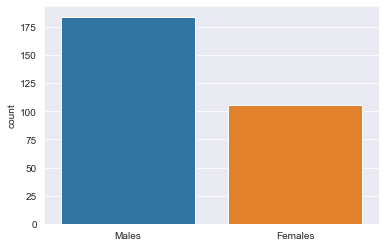

In [ ]:
lables = []
for i in y_train:
    if(i == 0):
        lables.append("Males")
    else:
        lables.append("Females")
sns.set_style('darkgrid')
sns.countplot(lables)


### Resize images to be 128*64 for HOG feature extraction

In [4]:
data_train_resized = resized_images(data=data_train, width= 64, height= 128)
data_test_resized = resized_images(data=data_test, width= 64, height= 128)

### Extract HOG Features

In [5]:
def apply_hog(data):
    featureVecs = []
    outputImgs = []
    for img in data:
        featureVecHog, hog_image = hog(img, orientations=9, pixels_per_cell=(16, 16),
                                       cells_per_block=(3, 3), visualize=True, multichannel=False)
        featureVecs.append(featureVecHog)
        outputImgs.append(hog_image)
    return featureVecs, outputImgs


In [6]:
training_HOG, traning_imgs = apply_hog(data_train_resized)


In [7]:
testing_HOG, testing_imgs = apply_hog(data_test_resized)

### LBP feature extraction using original images

In [8]:
def describe(numPoints, radius, image):
    # compute the Local Binary Pattern representation
    # of the image, and then use the LBP representation
    # to build the histogram of patterns
    lbp = local_binary_pattern(image, numPoints,
                               radius, method="uniform")        
    return lbp.flatten()

In [9]:
def apply_LBP(data, numPoints, Radius):
    featureVecs = []
    for img in data:
        res= describe(numPoints, Radius, img)
        featureVecs.append(res)
    return featureVecs

In [10]:
training_LBP = apply_LBP(data_train, 24, 3)
testing_LBP = apply_LBP(data_test, 24, 3)


### Applying GLCM Feature Extraction

In [ ]:
def apply_glcm(images, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    features=[]
    for img in images:
        glcm = greycomatrix(img, 
                            distances=dists, 
                            angles=agls, 
                            levels=lvl,
                            symmetric=sym, 
                            normed=norm)
        feature = []
        glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
        for item in glcm_props:
                feature.append(item)
        features.append(feature)
    
    return features

In [ ]:
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

training_GLCM = apply_glcm(data_train,properties)
testing_GLCM = apply_glcm(data_test,properties)

In [ ]:
all_training_feats = np.zeros((data_train.shape[0],training_HOG[0].shape[0]+training_LBP[0].shape[0] ))
all_testing_feats = np.zeros((data_test.shape[0], testing_HOG[0].shape[0]+testing_LBP[0].shape[0]))

In [ ]:
all_training_feats[:,0:training_HOG[0].shape[0]]= training_HOG
all_training_feats[:,training_HOG[0].shape[0]:(training_HOG[0].shape[0]+training_LBP[0].shape[0])]= training_LBP
all_testing_feats[:,0:testing_HOG[0].shape[0]]= testing_HOG
all_testing_feats[:,testing_HOG[0].shape[0]:(testing_HOG[0].shape[0]+testing_LBP[0].shape[0])]= testing_LBP

In [ ]:
print(len(training_HOG))
print(training_HOG[0].shape)
print(len(training_LBP))

print(training_LBP[0].shape)
print(all_training_feats.shape)

290
(632772,)
290
(10,)
(290, 632782)


## Training The Classifiers

In [11]:
def train_svm(data, y_train, C):
    # train a Linear SVM on the data
    model = LinearSVC(C=C, random_state=42)
    y_train =y_train.astype('int')
    model.fit(data, y_train)
    return model


In [12]:
def train_boosting(data, y_train):
    classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
    classifier.fit(data, y_train)
    return classifier

### Training SVM on all Features

In [ ]:
svm_m_all = train_svm(data=all_training_feats, y_train=y_train)
train_predicted_all = svm_m_all.predict(all_training_feats)
print(f"Training accuracy is %0.2f"%(np.sum(train_predicted_all == y_train)/len(y_train) * 100))
test_predicted_all = svm_m_all.predict(all_testing_feats)
print(f"Testing accuracy is %0.2f"%(np.sum(test_predicted_all == y_test)/len(y_test) * 100))

Training accuracy is 100.00
Testing accuracy is 69.86


## Training SVM on HOG feature only

In [ ]:
svm_m_HOG = train_svm(data=training_HOG, y_train=y_train,  C=100)
train_predicted_HOG = svm_m_HOG.predict(training_HOG)
print(f"Training accuracy is %0.2f"%(np.sum(train_predicted_HOG == y_train)/len(y_train) * 100))
test_predicted_HOG = svm_m_HOG.predict(testing_HOG)
print(f"Testing accuracy is %0.2f"%(np.sum(test_predicted_HOG == y_test)/len(y_test) * 100))


Training accuracy is 100.00
Testing accuracy is 76.67


c:\Users\Donia\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## Training GBC on HOG feature only

In [13]:
boosting_m_HOG = train_boosting(data=(training_HOG), y_train=np.array((y_train), dtype=np.uint8))
train_predicted_HOG = boosting_m_HOG.predict(training_HOG)
print(f"Training accuracy is %0.2f"%(np.sum(train_predicted_HOG == y_train)/len(y_train) * 100))
test_predicted_HOG = boosting_m_HOG.predict(testing_HOG)
print(f"Testing accuracy is %0.2f"%(np.sum(test_predicted_HOG == y_test)/len(y_test) * 100))


Training accuracy is 100.00
Testing accuracy is 83.33


## Training SVM on LBP feature only

In [ ]:
svm_m_LBP = train_svm(data=training_LBP, y_train=y_train, C=100)
train_predicted_LBP = svm_m_LBP.predict(training_LBP)
print(f"Training accuracy is %0.2f"%(np.sum(train_predicted_LBP == y_train)/len(y_train) * 100))
test_predicted_LBP = svm_m_LBP.predict(testing_LBP)
print(f"Testing accuracy is %0.2f"%(np.sum(test_predicted_LBP == y_test)/len(y_test) * 100))


## Training SVM on GLCM feature only

In [ ]:
svm_m_GLCM = train_svm(data=training_GLCM, y_train=y_train, C=100)
train_predicted_GLCM = svm_m_GLCM.predict(training_GLCM)
print(f"Training accuracy is %0.2f"%(np.sum(train_predicted_GLCM == y_train)/len(y_train) * 100))
test_predicted_GLCM = svm_m_GLCM.predict(testing_GLCM)
print(f"Testing accuracy is %0.2f"%(np.sum(test_predicted_GLCM == y_test)/len(y_test) * 100))

Training accuracy is 63.45
Testing accuracy is 65.75


c:\Users\Donia\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [ ]:
GridSearch_tuning(np.array((training_LBP), dtype=np.uint8), np.array(y_train, dtype=np.uint8))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.5s finished


{'C': 0.1, 'gamma': 1}

In [ ]:
print('Confusion Matrix')
cf = confusion_matrix(np.array((y_test), dtype=np.uint8), np.array(test_predicted_LBP, dtype=np.uint8))
cf_sum = cf.sum(axis = 1)[:, np.newaxis]
cf = np.round(cf / cf_sum * 100, 2)
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(repr(cf))

Confusion Matrix
array([[100.00, 0.00],
       [100.00, 0.00]])
